In [1]:
import fastcore.all as fc

In [2]:
import torch
from torch import nn
import os
from os import path
import torchvision
import torchvision.transforms as T
from typing import Sequence
from torchvision.transforms import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torchmetrics as TM

# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()

In [3]:
pets_path_train = './train'
pets_path_test = './test'

In [4]:
# Create a dataset wrapper that allows us to perform custom image augmentations
# on both the target and label (segmentation mask) images.
#
# These custom image augmentations are needed since we want to perform
# transforms such as:
# 1. Random horizontal flip
# 2. Image resize
#
# and these operations need to be applied consistently to both the input
# image as well as the segmentation mask.
class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform =  post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)
        
        # Common transforms are performed on both the input and the labels
        # by creating a 4 channel image and running the transform on both.
        # Then the segmentation mask (4th channel) is separated out.
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        # end if
        
        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)


In [5]:
 #Create a tensor for a segmentation trimap.
# Input: Float tensor with values in [0.0 .. 1.0]
# Output: Long tensor with values in {0, 1, 2}
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
    ]),
    post_transform=T.Compose([
        # Color Jitter as data augmentation.
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

# Create the train and test instances of the data loader for the
# Oxford IIIT Pets dataset with random augmentations applied.
# The images are resized to 128x128 squares, so the aspect ratio
# will be chaged. We use the nearest neighbour resizing algorithm
# to avoid disturbing the pixel values in the provided segmentation
# mask.
pets_train = OxfordIIITPetsAugmented(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=True,
    **transform_dict,
)
pets_test = OxfordIIITPetsAugmented(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=True,
    **transform_dict,
)

pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size=64,
    shuffle=True,
)
pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=21,
    shuffle=True,
)

(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))
train_pets_inputs.shape, train_pets_targets.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 1, 128, 128]))

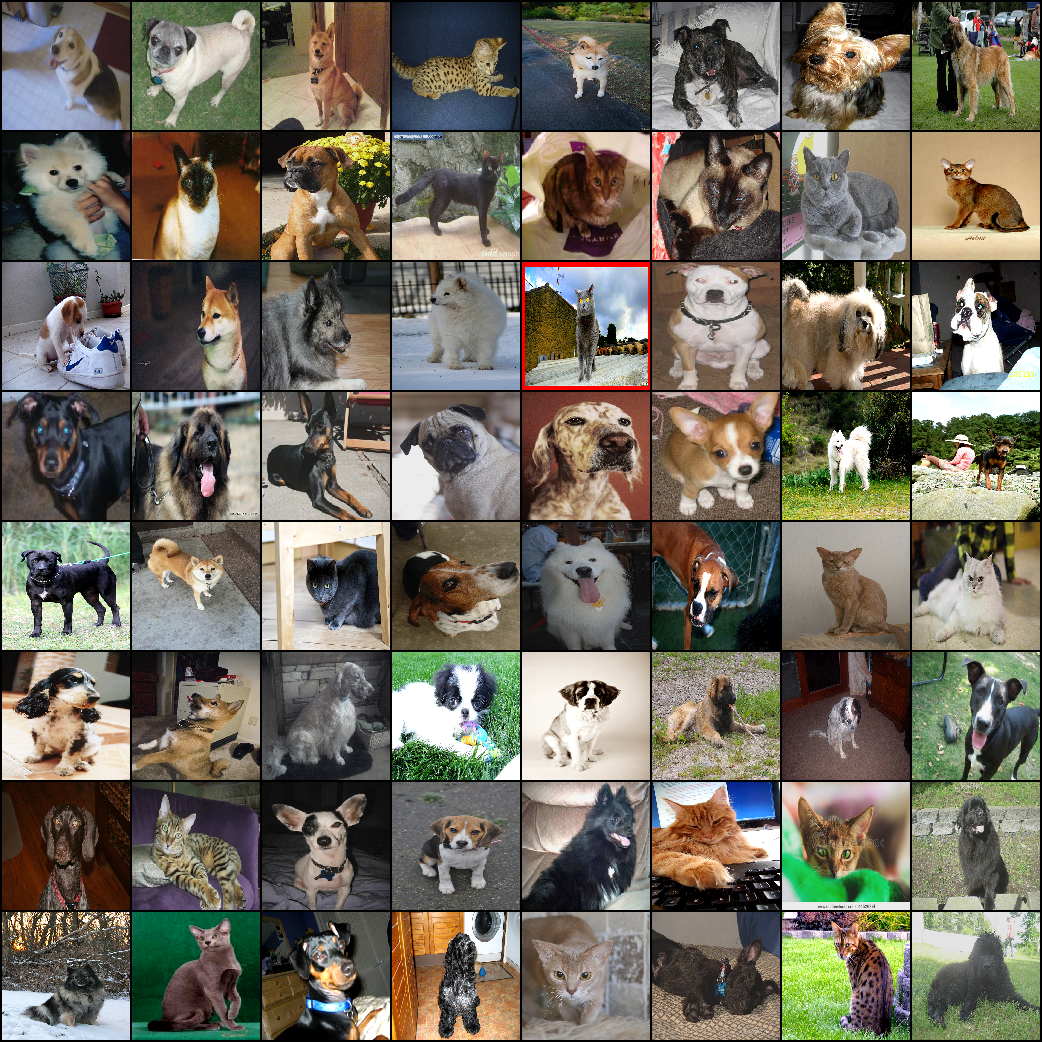

In [6]:
# Let's inspect some of the images.
pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
t2img(pets_input_grid)

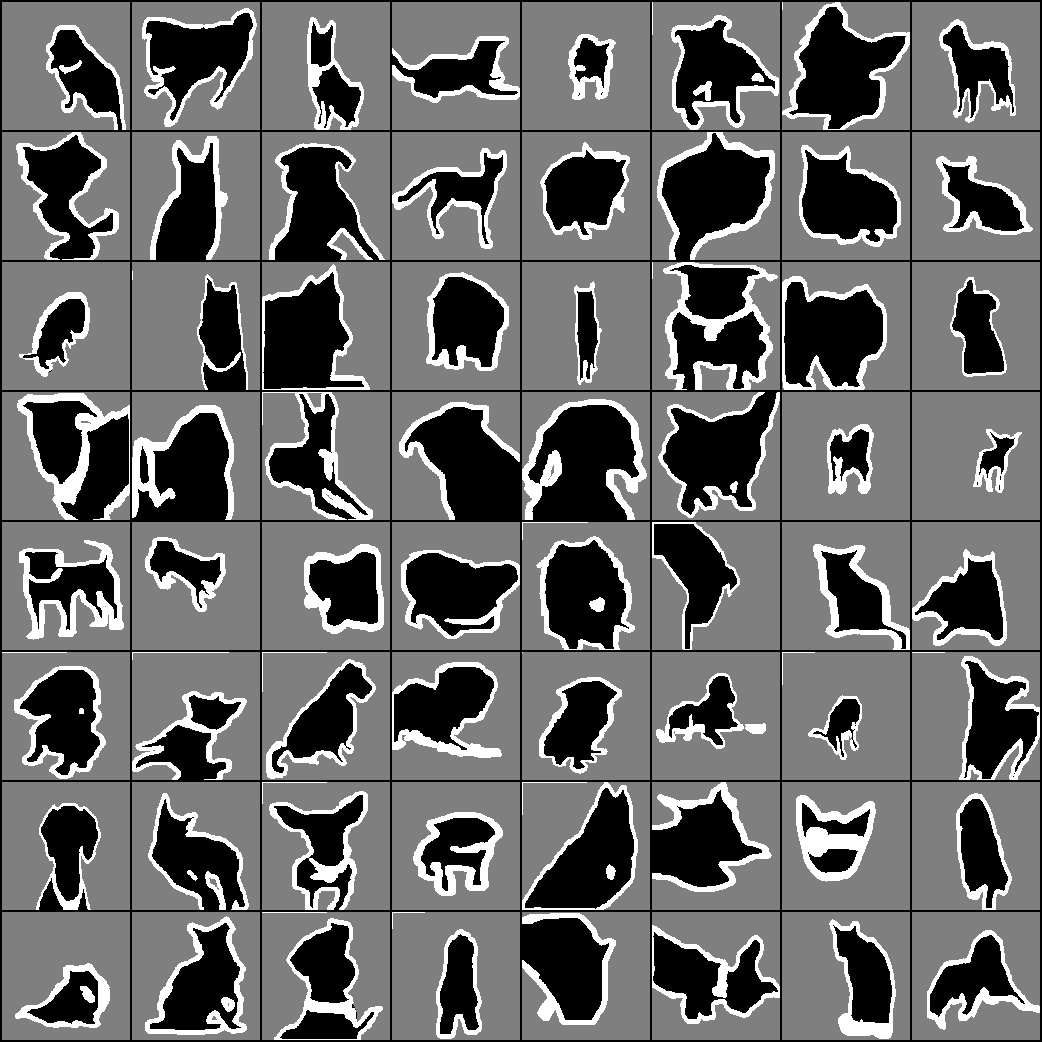

In [10]:
# Let's inspect the segmentation masks corresponding to the images above.
#
# When plotting the segmentation mask, we want to convert the tensor
# into a float tensor with values in the range [0.0 to 1.0]. However, the
# mask tensor has the values (0, 1, 2), so we divide by 2.0 to normalize.
pets_targets_grid = torchvision.utils.make_grid(train_pets_targets / 2.0, nrow=8)
t2img(pets_targets_grid)

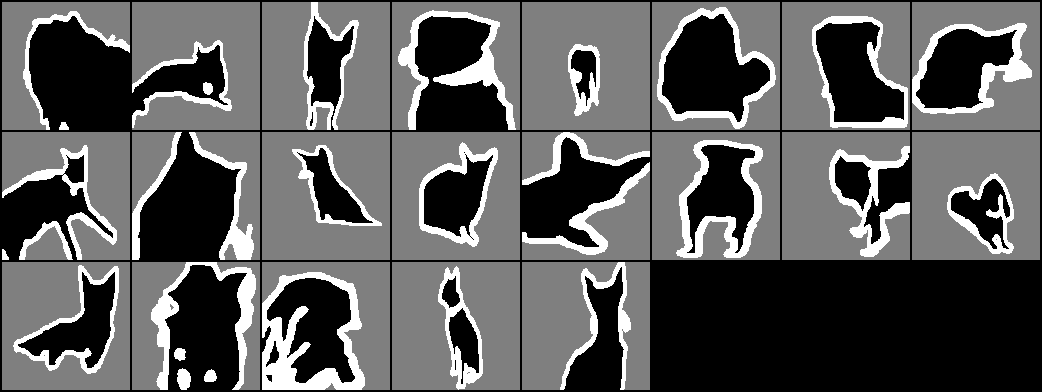

In [64]:
pets_targets_grid = torchvision.utils.make_grid(test_pets_targets / 2.0, nrow=8)
t2img(pets_targets_grid)

In [8]:
train_pets_targets.max(),train_pets_targets.min()

(tensor(2), tensor(0))

In [9]:
from learner import *
from datasets import *
from conv import *
from training import get_dls

In [77]:
dls = DataLoaders(*get_dls(pets_train,  pets_test, bs=256, num_workers=8))

In [65]:
xbs,yb = next(iter(dls.train))

In [66]:
yb.max(),yb.min()

(tensor(2), tensor(0))

In [69]:
xbs,yb = next(iter(dls.valid))

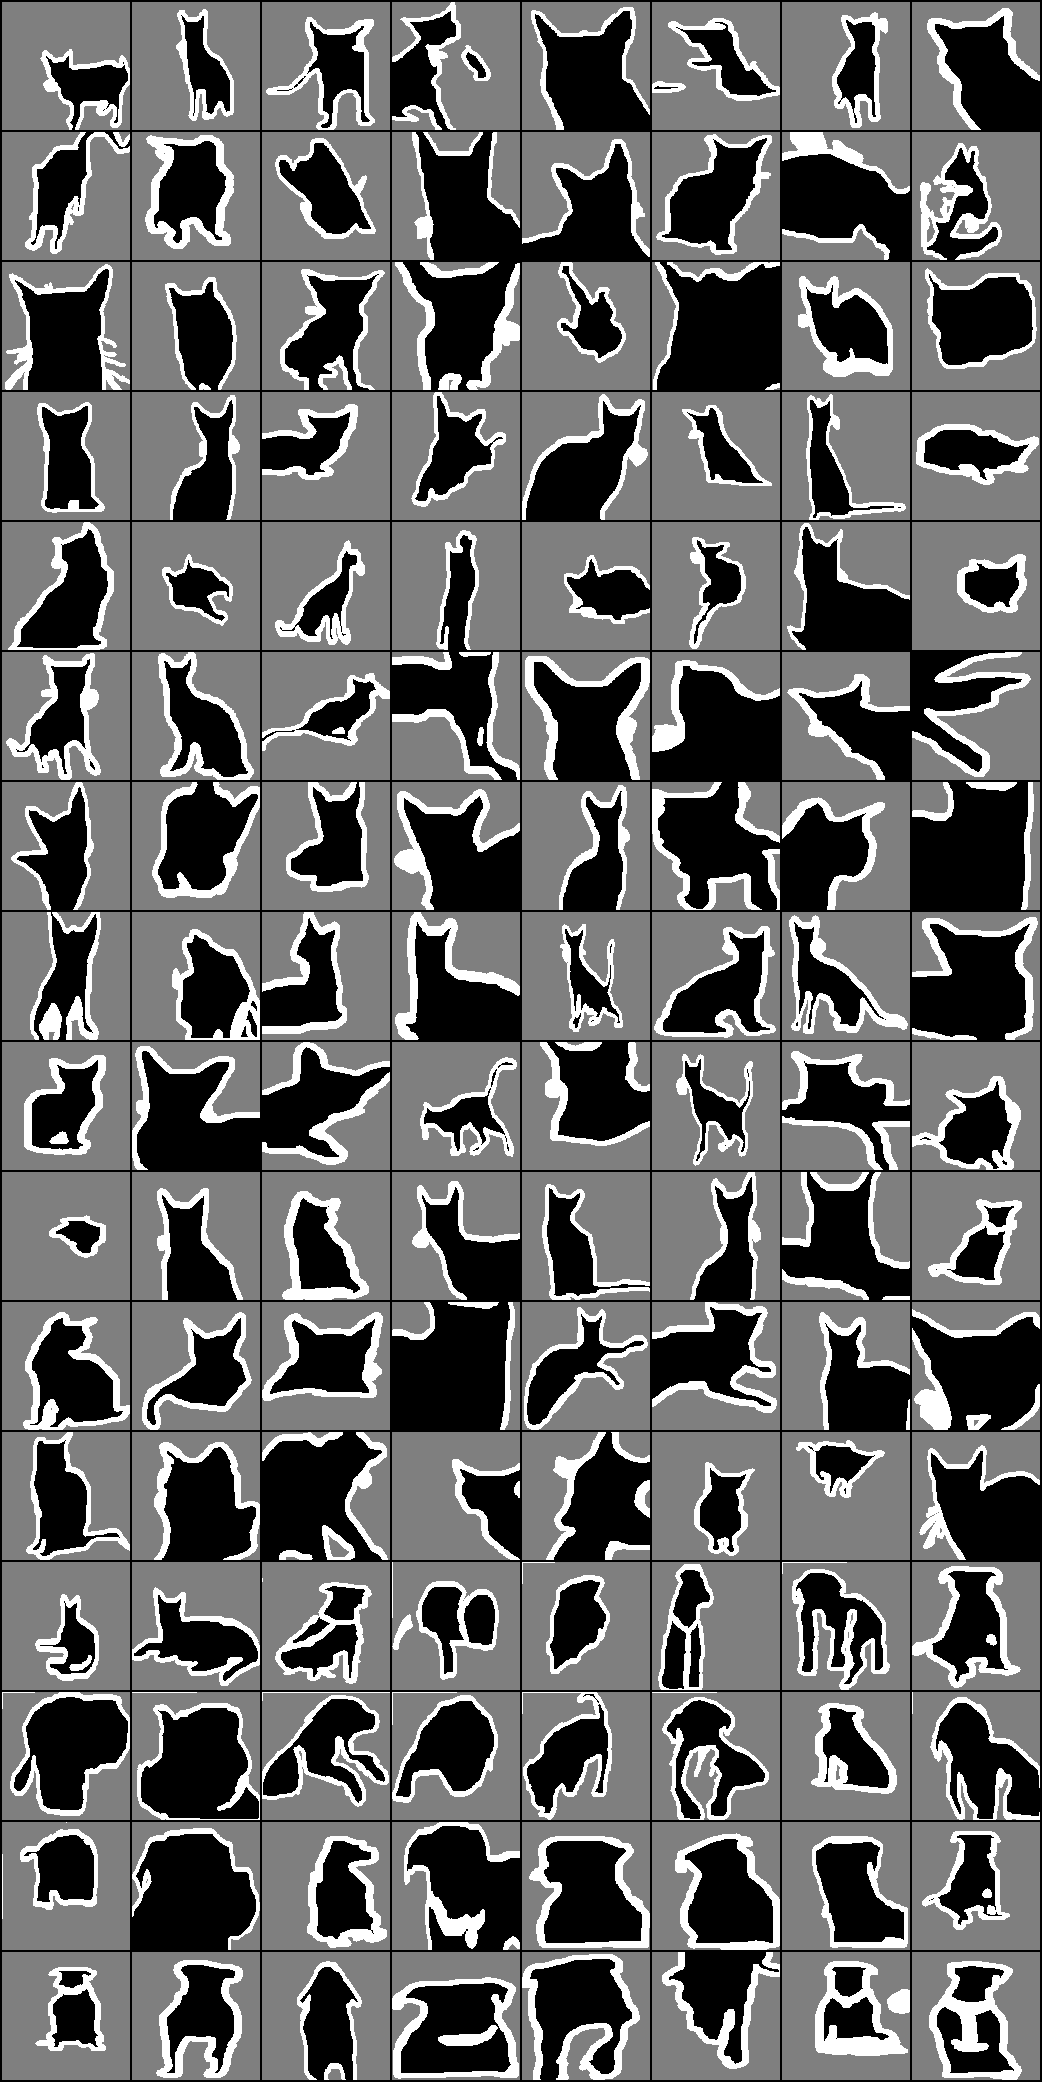

In [70]:
pet_yb = torchvision.utils.make_grid(yb / 2.0, nrow=8)
t2img(pet_yb)

In [22]:
count = 0
for i,_ in enumerate(dls.train):
    count +=1
print(f"the number of batches in train dl is: {count}")

    

the number of batches in train dl is: 15


In [23]:
count = 0
for i,_ in enumerate(dls.valid):
    count +=1
print(f"the number of batches in valid dl is: {count}")

the number of batches in valid dl is: 8


In [24]:
xb,yb = next(iter(dls.train))

In [25]:
xb.shape,yb.shape

(torch.Size([256, 3, 128, 128]), torch.Size([256, 1, 128, 128]))

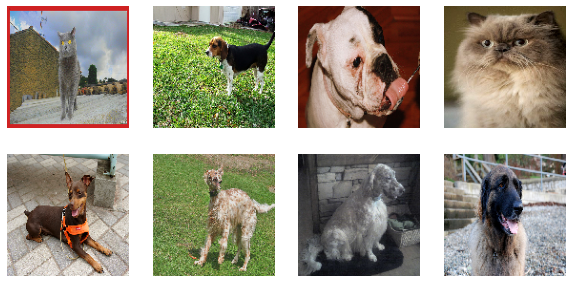

In [26]:
show_images(xb[:8], imsize=2.5)

In [11]:
yb.dtype

torch.float32

In [12]:
from functools import partial

In [78]:
import torch.nn as nn

class ContractingBlock(nn.Module):
    def __init__(self, in_channels, out_channels,max_pooling=True):
        super(ContractingBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool = fc.noop if (not max_pooling) else nn.AvgPool2d(2, ceil_mode=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        skip = x  # store the output for the skip connection
        x = self.pool(x)
        
        return x, skip

class ExpandingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ExpandingBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        
        
        self.upsample = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        
    def forward(self, x,skip=None):
        
        x = self.upsample(x)
        x = torch.cat((x, skip), dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        
        
        return x
    
class UNet(nn.Module):
    def __init__(self,in_channels=3, n_filters=32, n_classes=3):
        super(UNet, self).__init__()
        
        self.contract1 = ContractingBlock(in_channels, n_filters,max_pooling=True) 
        self.contract2 = ContractingBlock(n_filters, n_filters*2,max_pooling=True)
        self.contract3 = ContractingBlock( n_filters*2,  n_filters*4,max_pooling=True)
        self.contract4 = ContractingBlock( n_filters*4,  n_filters*8,max_pooling=True)
        self.contract5 = ContractingBlock( n_filters*8,  n_filters*16,max_pooling=False)
        
        self.expand1 = ExpandingBlock(n_filters*16, n_filters*8)
        self.expand2 = ExpandingBlock(n_filters*8, n_filters*4)
        self.expand3 = ExpandingBlock(n_filters*4, n_filters*2)
        self.expand4 = ExpandingBlock(n_filters*2, n_filters)
        
        self.pen_conv = conv(n_filters, n_classes, stride=1, act=True, ks=3)
        
        self.final_conv = conv(n_classes,n_classes, stride=1, act=False, ks=1)
        
    def forward(self, x):
        # Contracting path
        x, skip1 = self.contract1(x)
        x, skip2 = self.contract2(x)
        x, skip3 = self.contract3(x)
        x, skip4 = self.contract4(x)
        x, _ = self.contract5(x)
        
        # Expanding path
        x = self.expand1(x, skip4)
        x = self.expand2(x, skip3)
        x = self.expand3(x, skip2)
        x = self.expand4(x, skip1)
        
        x =  self.pen_conv(x)
        return self.final_conv(x)
        
         
        

    
    
        
        

In [79]:
model = UNet()

In [44]:
import torch

In [45]:
x = torch.randn(64,3,128,128)


In [46]:
y = model(x)

In [47]:
y.shape

torch.Size([64, 3, 128, 128])

In [48]:
y.max(),y.min()

(tensor(1.3238, grad_fn=<MaxBackward1>),
 tensor(-0.9291, grad_fn=<MinBackward1>))

In [35]:
y.squeeze(dim=1).shape

torch.Size([512, 3, 128, 128])

In [80]:
import torch
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10

    def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()

    def after_loss(self, learn): self.autocast.__exit__(None, None, None)

    def backward(self, learn): self.scaler.scale(learn.loss).backward()

    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

In [81]:
from torch import optim
from functools import partial

In [82]:
from torcheval.metrics import MulticlassAccuracy

In [83]:
metrics = MetricsCB()
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]
lr_cbs = [DeviceCB(), ProgressCB(), MixedPrecision()]
opt_func = partial(optim.Adam, eps=1e-5)

In [ ]:
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

In [84]:
import sys,gc,traceback
import fastcore.all as fc

In [85]:
# %% ../nbs/11_initializing.ipynb 11
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

# %% ../nbs/11_initializing.ipynb 12
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

# %% ../nbs/11_initializing.ipynb 13
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [86]:
clean_mem()

In [87]:
from torch.optim import lr_scheduler

In [88]:
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def _step(self, learn):
        if learn.training: self.schedo.step()

In [89]:
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)

In [90]:
from learner import TrainLearner
class Custom_Learner(TrainLearner):
    def predict(self): 
        self.preds = self.model(self.batch[0])
        #self.preds = torch.argmax(preds,dim=1,keepdims=True)
    def get_loss(self):
        self.loss = self.loss_func(self.preds, self.batch[1].squeeze(dim=1))

In [95]:
clean_mem()

In [27]:
cbs

In [74]:
import torch.nn.functional as F2

In [96]:
epochs = 20
lr = 1e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Custom_Learner(model, dls, nn.CrossEntropyLoss(reduction='mean'), lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
1.064,0,train
1.061,0,eval
1.064,1,train
1.057,1,eval
1.064,2,train
1.055,2,eval
1.063,3,train
1.059,3,eval
1.063,4,train
1.061,4,eval


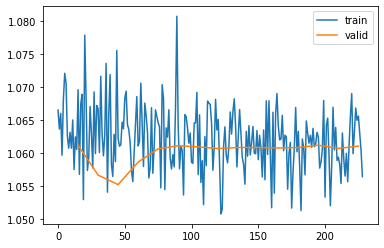

In [ ]:
learn.fit(epochs)

In [36]:
clean_mem()

In [37]:
device = 'cuda'
import matplotlib as plt
import matplotlib.pyplot as plt

In [40]:
# Results of Validation Dataset
def VisualizeResults(index):
    img,actual_mask = pets_test[index]
    img = img.unsqueeze(0)
    pred_y = model(img.to(device))
    pred = nn.Softmax(dim=0)(pred_y)
    pred_mask = pred.argmax(dim=0)
    #pred_mask = torch.argmax(pred_y, dim=1)
    #pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    show_image(img.squeeze(),ax = arr[0])
    arr[0].set_title('Processed Image')
    show_image(actual_mask,arr[1])
    arr[1].set_title('Actual Masked Image ')
    show_image(pred_mask,arr[2])
    arr[2].set_title('Predicted Masked Image ')

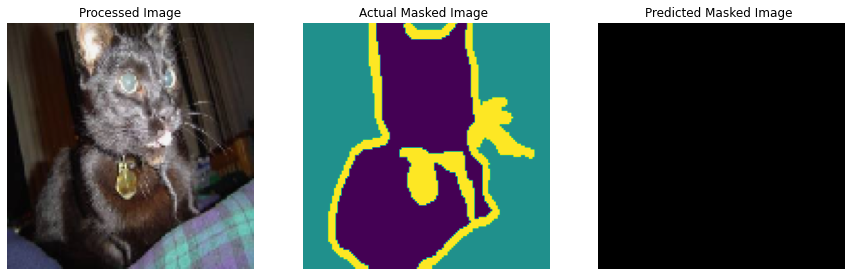

In [41]:
### Add any index to contrast the predicted mask with actual mask
index = 700
VisualizeResults(index)